In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import numpy as np
import nest
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams 
import unicodeit
import ipywidgets as widgets
from ipywidgets import interact
import inspect
from joblib import Memory
from consts import Paths
from pathlib import Path
from os import makedirs
from dataclasses import dataclass


CACHE_DIR = Path(Paths.DATA_DIR) / 'myoga_cache'
makedirs(CACHE_DIR, exist_ok=True)

nest.set_verbosity('M_ERROR') 
figures = {}
memory = Memory(location=CACHE_DIR, verbose=0)



              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.8.0
 Built: Aug 27 2024 04:33:06

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
# utility functions
def time_max_voltage(x):
    return x["times"][np.argmax(x["V_m"])] * 100


def plot_axes_legend(ax):
    ax.set_xlabel("Time (ms)")
    ax.legend()
    ax.set_ylabel("V_m")


def plot_voltage(ax, data, color="b", label="", linewidth=1, plot_max=True):
    if plot_max:
        ax.axvline(time_max_voltage(data), color=color, linewidth=0.5)
    ax.plot(data["V_m"], color=color, linewidth=linewidth, label=label)


def plot_threshold(ax, level=-55):
    ax.axhline(-55, color="k", linestyle="--")

import matplotlib


def heatmap(
    data, row_labels, col_labels, ax=None, cbar_kw=None, cbarlabel="", **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current Axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    len(data)
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right", rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1] + 1) - 0.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0] + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(
    im,
    data=None,
    valfmt="{x:.2f}",
    textcolors=("black", "white"),
    threshold=None,
    **textkw,
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max()) / 2.0

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


# MSO model
we'll just use the complete four input model as a basis, and create simpler model from here. since it's easy enough i think this is for the best

In [3]:
@dataclass
class ParamsMSO4:
    delay_exc_i: float = 5
    delay_exc_c: float = 5
    # delay_exc_i - delay_exc_c = ITD
    delay_inh_i: float = 5
    delay_inh_c: float = 5
    tone: int = 100
    tau_rise_exc: float = 0.2
    tau_rise_in: float = 0.2
    tau_decay_ex: float = 0.5
    tau_decay_in: float = 1.5
    weight_exc_i: float = 5
    weight_exc_c: float = 5
    weight_inh_i: float = -4
    weight_inh_c: float = -4
    I_ext: int = 0
    time_sim: int = 15
    v_th: int = -40
    c_mso: int = 1


@memory.cache
def mso(p: ParamsMSO4):
    nest.ResetKernel()
    nest.local_num_threads = 16
    nest.resolution = 0.01

    input = nest.Create(
        "spike_generator",
        params={
            "spike_times": np.around(np.arange(1, p.time_sim + 1, 1000 / p.tone), 2)
        },
    )
    mso = nest.Create(
        "iaf_cond_beta",
        params={
            "V_th": p.v_th,
            "C_m": p.c_mso,
            "tau_rise_ex": p.tau_rise_exc,
            "tau_rise_in": p.tau_rise_in,
            "tau_decay_ex": p.tau_decay_ex,
            "tau_decay_in": p.tau_decay_in,
            "I_e": p.I_ext,
        },
    )
    rec = nest.Create("multimeter", 1, {"record_from": ["V_m"], "interval": 0.01})

    nest.Connect(rec, mso, "all_to_all")
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_exc_i, "delay": p.delay_exc_i}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_exc_c, "delay": p.delay_exc_c}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_inh_i, "delay": p.delay_inh_i}
    )
    nest.Connect(
        input, mso, "one_to_one", syn_spec={"weight": p.weight_inh_c, "delay": p.delay_inh_c}
    )
    nest.Simulate(p.time_sim)
    return rec.get("events")

def angle_to_itd(angle,w_head:int = 22,v_sound:int = 33000):
    delta_x = (w_head*np.sin(np.deg2rad(angle)))
    return round(1000*delta_x/v_sound,2)


In [4]:
def paramsMSO2(
    delta_t: float = 0.4, weight_inh: float = -4, weight_exc: float = 4, **kwargs
) -> ParamsMSO4:
    params = ParamsMSO4(weight_inh_i=weight_inh, weight_exc_i=weight_exc, **kwargs)
    params.delay_inh_i = params.delay_exc_i + delta_t
    params.weight_exc_c = 0
    params.weight_inh_c = 0
    return params

# single PSP sum
this shows we can move peak voltage times. i included a slider for the inhibitory weight to show that changing the synaptic weight impacts the size of the shift considerably. what does this mean?

interactive(children=(FloatSlider(value=-0.4, description='delta_t', max=1.0, min=-1.5), IntSlider(value=-4, d…

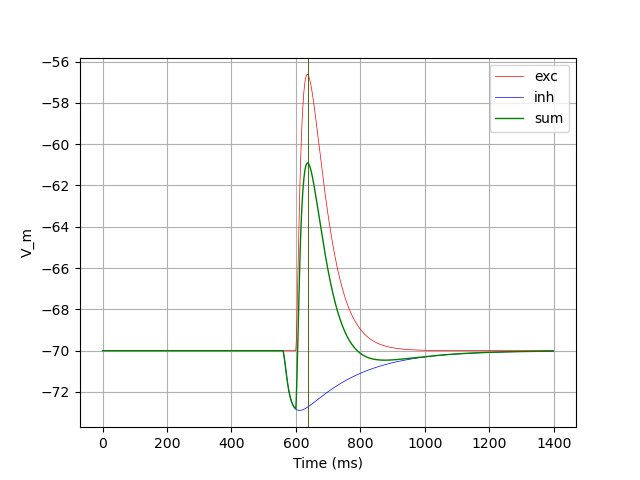

In [16]:
out = widgets.Output()


def show_mso_two_inputs(delta_t, weight_inh):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    only_ex = mso(paramsMSO2(delta_t=delta_t, weight_inh=0))
    only_inh = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh, weight_exc=0))
    res_sum = mso(paramsMSO2(delta_t=delta_t, weight_inh=weight_inh))
    plot_voltage(ax, only_ex, color="r", linewidth=0.5, label="exc")
    plot_voltage(ax, only_inh, color="b", linewidth=0.5, label="inh", plot_max=False)
    plot_voltage(ax, res_sum, color="g", linewidth=1, label="sum")
    plot_axes_legend(ax)
    print(
        unicodeit.replace(
            f"peak distance (t_{{no-inh}}-t_{{inh}}) = {time_max_voltage(only_ex) - time_max_voltage(res_sum)}"
        )
    )
    fig.show()
    p = paramsMSO2(delta_t=delta_t)
    print(f"ipsi exc -> {p.delay_exc_i}ms,\n     inh -> {p.delay_inh_i}ms")


if show_mso_two_inputs.__name__ in figures:
    plt.close(figures.pop(show_mso_two_inputs.__name__)[0])


display(
    widgets.interactive(
        show_mso_two_inputs,
        delta_t=widgets.FloatSlider(min=-1.5, max=1, step=0.1, value=-0.4),
        weight_inh=widgets.IntSlider(min=-20, max=0, step=1, value=-4),
    )
)

# Three inputs

In [6]:
def paramsMSO3(
    angle: float = 0,
    deltat_inh: float = 0,  # delay_exc_c - delay_inh
    weight_inh: float = 0,
    **kwargs
):
    params = ParamsMSO4(**kwargs, weight_inh_i=0, weight_inh_c=weight_inh)
    itd = angle_to_itd(angle)
    params.delay_exc_c = params.delay_exc_i + itd
    params.delay_inh_c = params.delay_exc_c + deltat_inh
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

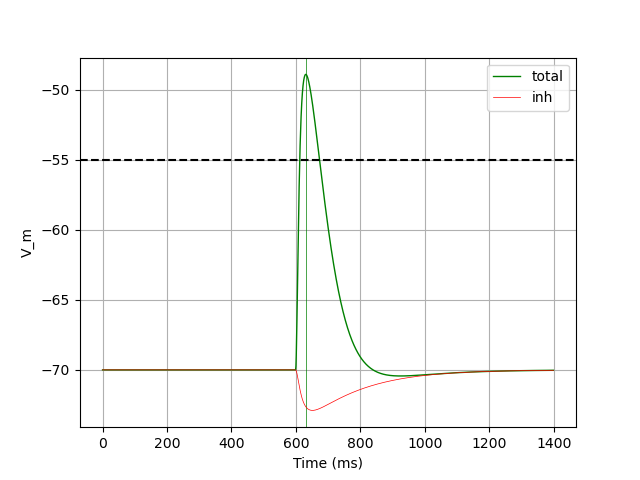

In [17]:
def show_mso_three_inputs(angle, deltat_inh, weight_inh):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    p = paramsMSO3(
        angle,
        deltat_inh=deltat_inh,
        weight_inh=weight_inh,
    )
    res_total = mso(p)
    only_inh = mso(paramsMSO2(weight_exc=0, delta_t=deltat_inh))
    plot_voltage(ax, res_total, "g", "total")
    plot_voltage(ax, only_inh, "r", "inh", linewidth=0.5,plot_max=False)
    plot_threshold(ax)
    plot_axes_legend(ax)
    print("this is a right-side MSO cell")
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\n\t\t\t     inh -> {p.delay_inh_c}ms"
    )
    fig.show()

if show_mso_three_inputs.__name__ in figures:
    plt.close(figures.pop(show_mso_three_inputs.__name__)[0])



display(
    widgets.interactive(
        show_mso_three_inputs,
        angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
        deltat_inh=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        weight_inh=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
    )
)

# Four inputs

In [8]:
def paramsMSO4(
    angle:float=0,
    deltat_inhi:float=0, # delay_exc_i - delay_inh_i
    deltat_inhc:float=0, # delay_exc_c - delay_inh_c
    **kwargs
):
    params=ParamsMSO4(**kwargs)
    itd = angle_to_itd(angle)
    params.delay_exc_c = params.delay_exc_i + itd
    params.delay_inh_i = params.delay_exc_i + deltat_inhi
    params.delay_inh_c = params.delay_exc_c + deltat_inhc
    return params

interactive(children=(IntSlider(value=0, description='angle', max=90, min=-90, step=15), FloatSlider(value=0.0…

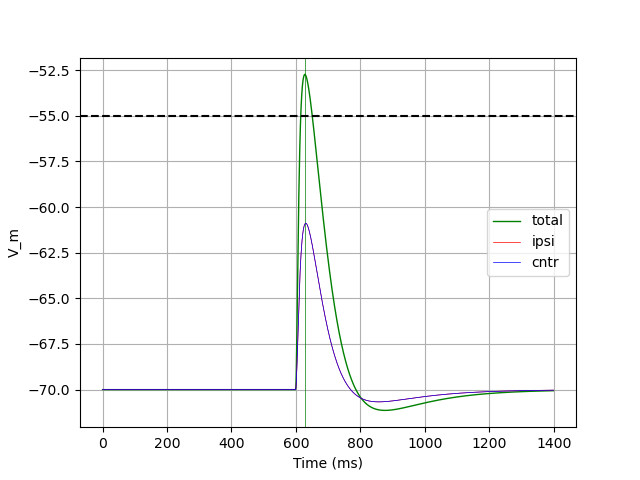

In [18]:
def show_mso_four_inputs(angle, deltat_inhi, deltat_inhc, weight_inh_i, weight_inh_c):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]
    p = paramsMSO4(
        angle,
        deltat_inhi,
        deltat_inhc,
        weight_inh_i=weight_inh_i,
        weight_inh_c=weight_inh_c,
    )
    res_total = mso(p)
    res_ipsi = mso(paramsMSO2(delta_t=deltat_inhi, weight_inh=weight_inh_i))
    res_contra = mso(
        paramsMSO2(
            delta_t=deltat_inhc,
            weight_inh=weight_inh_c,
            delay_exc_i=p.delay_exc_i + angle_to_itd(angle),
        )
    )
    max_total= time_max_voltage(res_total)
    # res_only_inh = mso(paramsMSO4())
    plot_voltage(ax, res_total, "g", "total")
    plot_voltage(ax, res_ipsi, "r", "ipsi", linewidth=0.5, plot_max=False)
    plot_voltage(ax, res_contra, "b", "cntr", linewidth=0.5, plot_max=False)
    plot_threshold(ax)
    plot_axes_legend(ax)
    print(
        f"ipsi exc -> {p.delay_exc_i}ms,\tcntr exc -> {p.delay_exc_c}ms,\nipsi inh -> {p.delay_inh_i}ms,\tcntr inh -> {p.delay_inh_c}ms"
    )
    print(f"peak time {max_total}")
    fig.show()


if show_mso_four_inputs.__name__ in figures:
    plt.close(figures.pop(show_mso_four_inputs.__name__)[0])


display(
    widgets.interactive(
        show_mso_four_inputs,
        angle=widgets.IntSlider(min=-90, max=90, step=15, value=0),
        deltat_inhi=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        deltat_inhc=widgets.FloatSlider(min=-1.5, max=1, step=0.1),
        weight_inh_i=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
        weight_inh_c=widgets.IntSlider(min=-15, max=0, step=1, value=-4),
    )
)

interactive(children=(IntSlider(value=-6, description='weight_inh_i', max=0, min=-15), IntSlider(value=-1, des…

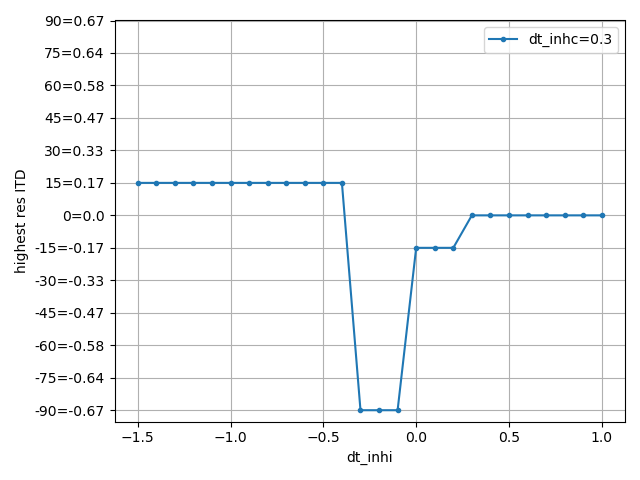

In [20]:
@memory.cache
def best_itd_curve(deltat_inhc, angles, weight_inh_i, weight_inh_c):
    deltat_inhis = [i / 10 for i in (range(-15, 11, 1))]
    max_for_deltat_inhi = []
    for deltat_inhi in deltat_inhis:
        res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inh_i,
                weight_inh_c=weight_inh_c,
            )
            res_total = mso(p)
            res[angle] = np.max(res_total["V_m"])
        max_for_deltat_inhi.append(max(res, key=res.get))
    return deltat_inhis, max_for_deltat_inhi


def show_inhi_influence_on_best_itd(weight_inh_i, weight_inh_c):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    angles = list(range(-90, 91, 15))
    deltat_inhcs = [i / 10 for i in (range(-15, 11, 1))]
    deltat_inhcs = [0.3]
    for deltat_inhc in deltat_inhcs:
        deltat_inhis, max_for_deltat_inhi = best_itd_curve(
            deltat_inhc, angles, weight_inh_i, weight_inh_c
        )
        ax.plot(
            deltat_inhis,
            max_for_deltat_inhi,
            marker=".",
            label=f"dt_inhc={deltat_inhc}",
        )

    ax.set_yticks(angles, labels=[f"{i}={angle_to_itd(i)}" for i in angles])
    ax.set_xlabel("dt_inhi")
    ax.set_ylabel("highest res ITD")
    plt.tight_layout()
    ax.legend()
    fig.show()


if show_inhi_influence_on_best_itd.__name__ in figures:
    plt.close(figures.pop(show_inhi_influence_on_best_itd.__name__)[0])


plt.rcParams["axes.grid"] = True

display(
    widgets.interactive(
        show_inhi_influence_on_best_itd,
        # deltat_inhc=widgets.FloatSlider(min=-1.5, max=1, step=0.1, value=0.2),
        weight_inh_i=widgets.IntSlider(min=-15, max=0, step=1, value=-6),
        weight_inh_c=widgets.IntSlider(min=-15, max=0, step=1, value=-1),
    )
)

now checking dt_inhc=-0.6
now checking dt_inhc=-0.5
now checking dt_inhc=-0.4
now checking dt_inhc=-0.3
now checking dt_inhc=-0.2
now checking dt_inhc=-0.1
now checking dt_inhc=0.0
now checking dt_inhc=0.1
now checking dt_inhc=0.2
now checking dt_inhc=0.3
now checking dt_inhc=0.4
now checking dt_inhc=0.5


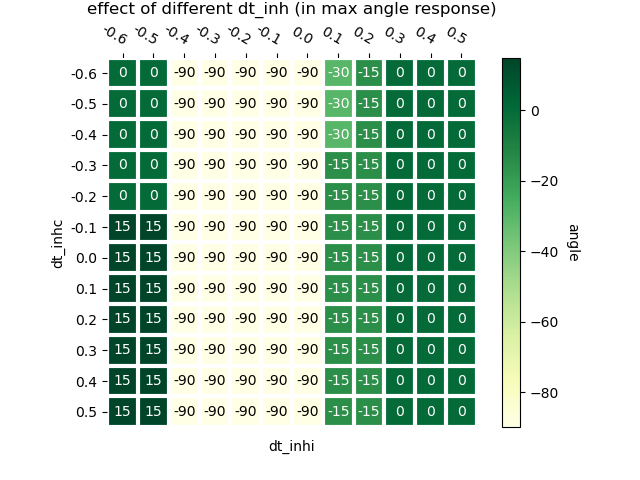

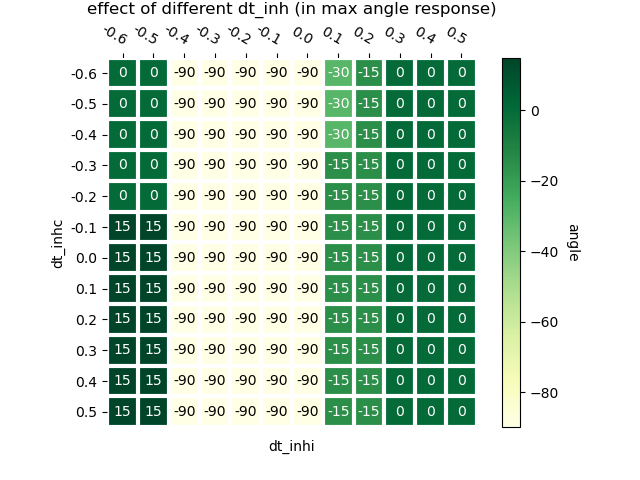

In [21]:


@memory.cache
def best_itd_per_inhi(deltat_inhc, deltat_inhis, angles, weight_inh_i, weight_inh_c):
    max_for_deltat_inhi = []
    for deltat_inhi in deltat_inhis:
        res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inh_i,
                weight_inh_c=weight_inh_c,
            )
            res_total = mso(p)
            res[angle] = np.max(res_total["V_m"])
        max_for_deltat_inhi.append(max(res, key=res.get))
    return deltat_inhis, max_for_deltat_inhi


def show_dt_impact_on_best_itd(weight_inh_i, weight_inh_c):
    # first run needs to create the plot
    my_name = inspect.currentframe().f_code.co_name
    if my_name not in figures.keys() or not figures[my_name][0].get_visible():
        figures[my_name] = plt.subplots(1, 1)
    fig, ax = figures[my_name]
    [l.remove() for l in ax.lines]

    angles = list(range(-90, 91, 15))
    deltat_inhcs = [i / 10 for i in (range(-6, 6, 1))]
    deltat_inhis = [i / 10 for i in (range(-6, 6, 1))]
    # deltat_inhcs = [i / 10 for i in (range(-14, 10, 1))]
    # deltat_inhis = [i / 10 for i in (range(-14, 10, 1))]
    max_angle = []
    # [inhc_row: [result_per_inhi,]]
    # deltat_inhcs = [0.3]
    for deltat_inhc in deltat_inhcs:
        print(f"now checking dt_inhc={deltat_inhc}")
        deltat_inhis, max_for_deltat_inhi = best_itd_per_inhi(
            deltat_inhc, deltat_inhis, angles, weight_inh_i, weight_inh_c
        )
        max_angle.append(max_for_deltat_inhi)

    im, cbar = heatmap(
        np.array(max_angle),
        [str(i) for i in deltat_inhis],
        [str(i) for i in deltat_inhcs],
        ax=ax,
        cmap="YlGn",
        cbarlabel="angle",
    )
    texts = annotate_heatmap(im, valfmt="{x:.0f}")

    ax.set_xlabel("dt_inhi")
    ax.set_ylabel("dt_inhc")
    ax.set_title("effect of different dt_inh (in max angle response)")
    ax.grid(False)
    # plt.tight_layout()
    fig.show()


if show_dt_impact_on_best_itd.__name__ in figures:
    plt.close(figures.pop(show_dt_impact_on_best_itd.__name__)[0])


WEIGHT_INH_I = -8
WEIGHT_INH_C = -1

show_dt_impact_on_best_itd(WEIGHT_INH_I,WEIGHT_INH_C)

now checking w_inhc=-12.0
now checking w_inhc=-11.6
now checking w_inhc=-11.2
now checking w_inhc=-10.8
now checking w_inhc=-10.4
now checking w_inhc=-10.0
now checking w_inhc=-9.6
now checking w_inhc=-9.2
now checking w_inhc=-8.8
now checking w_inhc=-8.4
now checking w_inhc=-8.0
now checking w_inhc=-7.6
now checking w_inhc=-7.2
now checking w_inhc=-6.8
now checking w_inhc=-6.4


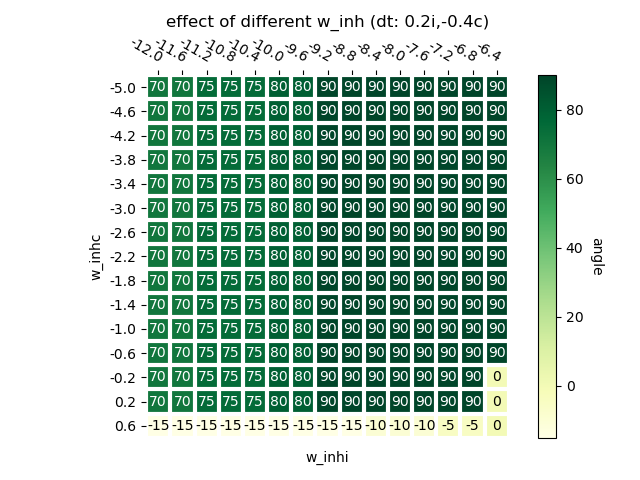

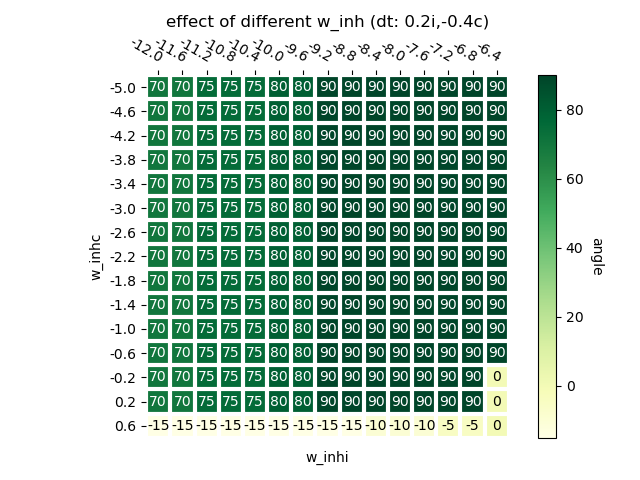

In [24]:
# %%script false --no-raise-error # correction


@memory.cache
def best_itd_per_w_inhi(deltat_inhi, deltat_inhc, angles, weight_inhis, weight_inhc):
    max_for_weight_inhi = []
    for weight_inhi in weight_inhis:
        res = {}
        for angle in angles:
            p = paramsMSO4(
                angle,
                deltat_inhi,
                deltat_inhc,
                weight_exc_i=2,
                weight_exc_c=2,
                weight_inh_i=weight_inhi,
                weight_inh_c=weight_inhc,
            )
            res_total = mso(p)
            res[angle] = np.max(res_total["V_m"])
        max_for_weight_inhi.append(max(res, key=res.get))
    return max_for_weight_inhi


def show_winh_impact_on_best_itd(dt_inhi, dt_inhc):
    fig, ax = plt.subplots(1, 1)

    angles = list(range(-90, 91, 5))
    w_inhcs = [i/10 for i in range(-120, -60, 4)]
    w_inhis = [i/10 for i in range(-50, 10, 4)]
    max_angle = []
    # [inhc_row: [result_per_inhi,]]
    # deltat_inhcs = [0.3]
    for w_inhc in w_inhcs:
        print(f"now checking w_inhc={w_inhc}")
        max_for_w_inhi = best_itd_per_w_inhi(
            dt_inhi, dt_inhc, angles, w_inhis, w_inhc
        )
        max_angle.append(max_for_w_inhi)

    im, cbar = heatmap(
        np.array(max_angle),
        [str(i) for i in w_inhis],
        [str(i) for i in w_inhcs],
        ax=ax,
        cmap="YlGn",
        cbarlabel="angle",
    )
    texts = annotate_heatmap(im, valfmt="{x:.0f}")

    ax.set_xlabel("w_inhi")
    ax.set_ylabel("w_inhc")
    ax.set_title(f"effect of different w_inh (dt: {dt_inhi}i,{dt_inhc}c)")
    ax.grid(False)
    plt.tight_layout()
    fig.show()

# if show_winh_impact_on_best_itd.__name__ in figures:
#     plt.close(figures.pop(show_winh_impact_on_best_itd.__name__)[0])



DT_INHI = 0.2
DT_INHC = -0.4

# dt_inh = [-0.5,-0.2,0, 0.1]

# for DT_INHI in dt_inh:
#     for DT_INHC in dt_inh:
show_winh_impact_on_best_itd(DT_INHI, DT_INHC)